# Customer_Lifetime_Value and RFM analysis on online retail dataset

In this notebook I will use  [dataset](https://https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering) containing information about all the transactions occurring from December 1st 2010 until December 9th 2011 for a UK-based and registered non-store online retail. The store sells gifts. The dataset contains specific information about the transaction number, quantity of purchased goods, price, country of sale and the buyer's ID. 

My goals are to manipulate the dataset as follows: 

1. Creation of RFM analysis (Recency Frequency Monetary)
2. Creating the concept of Customer Lifetime Value With Probabilistic Model

#1 RFM Analysis

In [1]:
#Import nedeed libraries

import sys
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
!pip install lifetimes
import lifetimes as lifetimes

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from collections import Counter
from PIL import Image
from pathlib import Path

import calendar
!pip install termcolor
from termcolor import colored
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Reading data and preprocessing

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding="ISO-8859-1")
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
#General information about the dataset

df.info()
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
Number of rows in dataset is:  541909
Number of columns in dataset is:  8


In [4]:
#Percentage of duplicate data
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))

#Remove duplicate data
df.drop_duplicates(inplace = True)

1% rows are duplicate.


In [5]:
#Formatting CustomerID to string type

df['CustomerID'] = df['CustomerID'].astype(str)
df.describe()

,Quantity,UnitPrice
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [6]:
#Total number of products, transactions and customers.

pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].unique().tolist()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4373


In [10]:
#Delete cancelled orders

cancel= df['InvoiceNo'].astype(str).str.contains('C')
cancel.fillna(0, inplace=True)
cancel = cancel.astype(int)
cancel.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [11]:
df['order_canceled'] = cancel
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0


In [ ]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print("Number of cancelled transactions:", n1)
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))
df = df[df['order_canceled'] == 0]

Number of cancelled transactions: 9251
Number of orders canceled: 9251/536641 (1.72%) 


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,0


In [ ]:
#Delete transactions with lack of CustomerID

df = df[df['CustomerID'].notna()]

In [15]:
#Check for negative values in Quantity

df[df['Quantity'] <= 0 ]['Quantity'].count()

10587

In [16]:
##Check for negative values in UnitPrice

df[df['UnitPrice'] <= 0 ]['UnitPrice'].count()

2512

In [18]:
#Creating new dataset without negative or zero values

df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]

In [19]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  524878
Number of columns in dataset is:  9


##Create Recency Frequency Monetary (RFM)

In [20]:
print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

Start date: 01-02-2011 08:23
End date: 31-10-2011 17:13


In [21]:
# Create revenue colummn
df['Revenue'] = df['UnitPrice'] * df['Quantity']
# Convert to show date only
from datetime import datetime
df["InvoiceDate"] = df["InvoiceDate"].dt.date

In [22]:
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)

In [23]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Revenue': 'MonetaryValue'}, inplace=True)

In [24]:
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,327,1,77183.60
1,12347.0,41,182,4310.00
2,12348.0,77,31,1797.24
3,12349.0,20,73,1757.55
4,12350.0,312,17,334.40


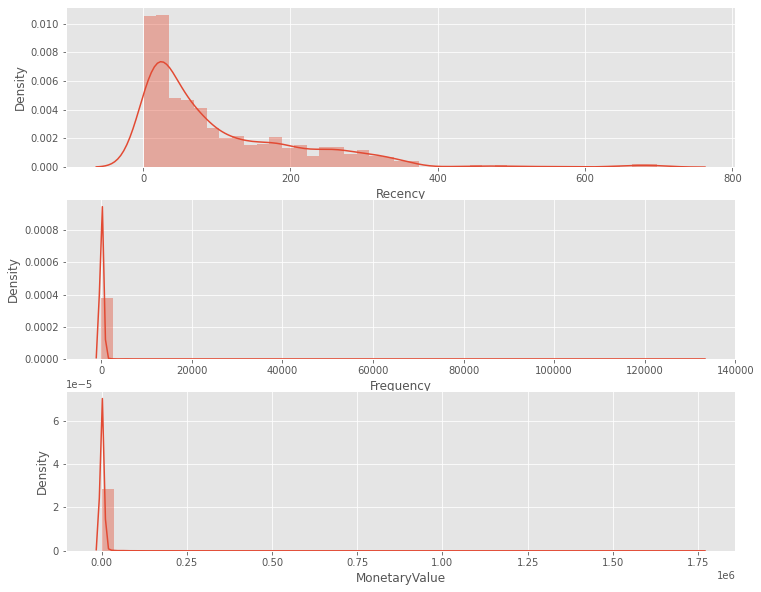

In [25]:
plt.figure(figsize=(12,10))
plt.style.use('ggplot')

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])

# Show the plot
plt.show()

In [ ]:
#Manage the skewness

from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))
    
    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

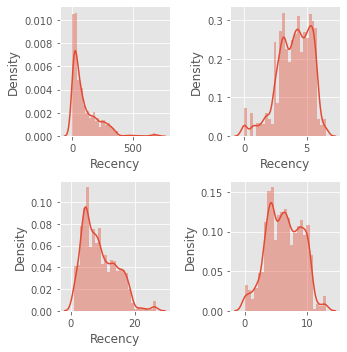

Log Transform : The skew coefficient of 1.92 to -0.66
Square Root Transform : The skew coefficient of 1.92 to 0.7
Box-Cox Transform : The skew coefficient of 1.92 to -0.05


In [ ]:
analyze_skewness('Recency')

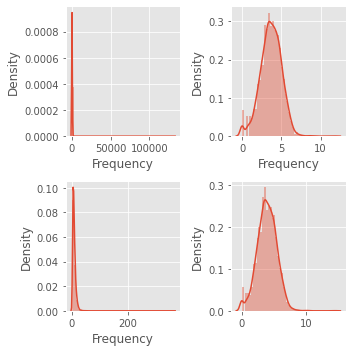

Log Transform : The skew coefficient of 64.67 to -0.17
Square Root Transform : The skew coefficient of 64.67 to 23.58
Box-Cox Transform : The skew coefficient of 64.67 to 0.01


In [ ]:
analyze_skewness('Frequency')

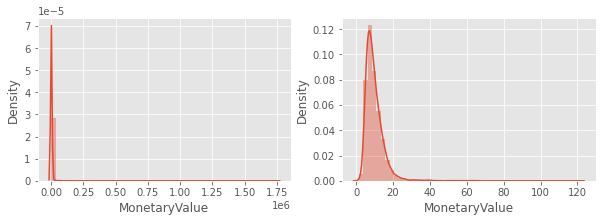

56.65
4.73


In [26]:
#Use cubic root transformation to the data

fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm['MonetaryValue']).skew().round(2))

In [27]:
pd.Series(np.cbrt(rfm['MonetaryValue'])).values

array([ 42.57699537,  16.27392924,  12.15818345, ...,  12.69410105,
        12.24781024, 120.61952546])

In [28]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4334,1.884993,2.013090,4.323541
4335,9.408033,2.595151,5.625753
4336,3.043265,7.392321,12.694101
4337,0.000000,4.577527,12.247810
4338,0.000000,14.569196,120.619525


In [29]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0. -0. -0.]
[1. 1. 1.]


In [30]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,1.543206,-2.628490,6.258254
1,-0.344169,1.164525,1.221374
2,0.151656,-0.203112,0.433234
3,-0.840626,0.448175,0.415967
4,1.491710,-0.648547,-0.565826


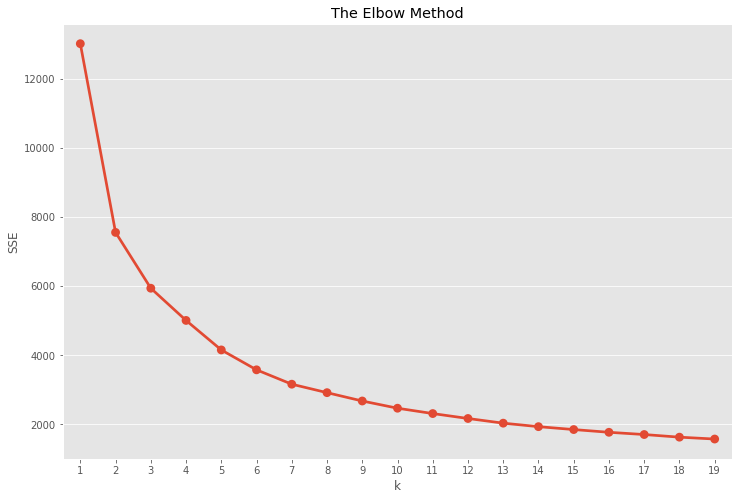

In [31]:
#Use the elbow method to decide which hyperparameter fits to the data

plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    
    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]
    
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.4792905696248644
2 : 1.102889486673822
3 : 0.9750685749141293
4 : 0.921120991571904
5 : 0.8447251091855169
6 : 0.7762455017264123
7 : 0.7248457173488594
8 : 0.7100377562071535
9 : 0.6910672347714992
10 : 0.6597827786894014
11 : 0.6396373303294925
12 : 0.618288277713905
13 : 0.5980709891490059
14 : 0.5830056139058697
15 : 0.5737854918872228
16 : 0.5531634769648569
17 : 0.5466987632794729
18 : 0.5400157387846115
19 : 0.5226745290058229


In [32]:
#Fit the model with 3 clusters

model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4339,)

In [33]:
rfm.shape

(4339, 4)

In [34]:
rfm["Cluster"] = model.labels_
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12346.0,327,1,77183.60,2
1,12347.0,41,182,4310.00,2
2,12348.0,77,31,1797.24,0
3,12349.0,20,73,1757.55,0
4,12350.0,312,17,334.40,1


In [ ]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          46.7      71.3        1120.5  1875
1         198.7      21.7         417.8  1793
2          27.0     524.8       11612.6   671

In [ ]:
#Fit the model with 4 clusters for comparing the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 cluster data. 

model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          39.5     190.7        3103.2  1279
1         226.0      24.9         454.1  1525
2          22.3    2615.5       69826.8    72
3          44.6      37.4         651.4  1463

In [ ]:
# Create the dataframe with 4 clusters
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.543206,-2.628490,6.258254,0,2
1,-0.344169,1.164525,1.221374,1,0
2,0.151656,-0.203112,0.433234,2,3
3,-0.840626,0.448175,0.415967,3,0
4,1.491710,-0.648547,-0.565826,4,1


In [ ]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,2,Recency,1.543206
1,1,0,Recency,-0.344169
2,2,3,Recency,0.151656
3,3,0,Recency,-0.840626
4,4,1,Recency,1.491710


In [ ]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13017 entries, 0 to 13016
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         13017 non-null  int64  
 1   Cluster    13017 non-null  int32  
 2   Attribute  13017 non-null  object 
 3   Value      13017 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 356.1+ KB


In [ ]:
# Aggregate data by each customer
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,3837,29.5
1,1,4575,35.1
2,2,216,1.7
3,3,4389,33.7


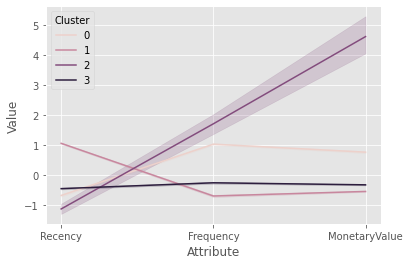

In [ ]:
# The four clusters seem to be separate from each other, which indicates a good heterogeneous mix of clusters
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

From the information above, we can conclude and correlate the clusters with customer groups


0	**New customers** 34%	Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.

1	**Old Customers**	31%	Customer who made their last transaction a while ago and who made frequent and large purchases in the past.

2	**Lost customers**	27%	Customers who made their last transaction a long time ago, and who have made few purchases.

3	**Loyal customers**	8%	Most frequent customers with the highest monetary spending amount and transact most recently

#2 Customer Lifetime Value

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12,3.39,17850.0,United Kingdom,0,20.34


In [ ]:
df.describe()

,Quantity,UnitPrice,order_canceled,Revenue
count,524878.000000,524878.000000,524878.0,524878.000000
mean,10.616600,3.922573,0.0,20.275399
std,156.280031,36.093028,0.0,271.693566
min,1.000000,0.001000,0.0,0.001000
25%,1.000000,1.250000,0.0,3.900000
50%,4.000000,2.080000,0.0,9.920000
75%,11.000000,4.130000,0.0,17.700000
max,80995.000000,13541.330000,0.0,168469.600000


In [37]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [38]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

In [39]:
df.describe()

,Quantity,UnitPrice,order_canceled,Revenue
count,524878.000000,524878.000000,524878.0,524878.000000
mean,7.127433,3.053662,0.0,20.275399
std,8.114955,2.609927,0.0,271.693566
min,1.000000,0.420000,0.0,0.001000
25%,1.000000,1.250000,0.0,3.900000
50%,4.000000,2.080000,0.0,9.920000
75%,11.000000,4.130000,0.0,17.700000
max,30.000000,9.950000,0.0,168469.600000


In [42]:
#Filtering only UK

df = df[df.Country == 'United Kingdom']

In [43]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-01-12,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-01-12,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34


In [44]:
#Creaing total price

df['Price'] = df['UnitPrice'] * df['Quantity']

In [45]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,Revenue,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-01-12,2.55,17850.0,United Kingdom,0,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-01-12,2.75,17850.0,United Kingdom,0,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-01-12,3.39,17850.0,United Kingdom,0,20.34,20.34


In [54]:
#Creating again new RFM where 'CustomerID' = CustomerId,'InvoiceDate' = Recency,'Total Price' = T, observation_period_end='2011-12-09' = Monetary_Value

new = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Price',observation_period_end='2011-12-09')

In [51]:
new = new[new['frequency']>1] # we want only customers shopped more than 2 times
new.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,554.0,576.0,365.255000
12748.0,112.0,692.0,696.0,247.955804
12749.0,3.0,313.0,335.0,705.523333
12820.0,3.0,282.0,326.0,255.733333
12823.0,4.0,222.0,296.0,229.500000


In [52]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(new['frequency'], new['recency'], new['T'])


<lifetimes.BetaGeoFitter: fitted with 1733 subjects, a: 0.00, alpha: 154.09, b: 0.00, r: 2.71>

In [53]:
#Summary of BG Model

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.705026e+00,0.115802,2.478054,2.931997
alpha,1.540894e+02,7.146707,140.081902,168.096995
a,3.331677e-23,NaN,NaN,NaN
b,8.800640e-13,NaN,NaN,NaN


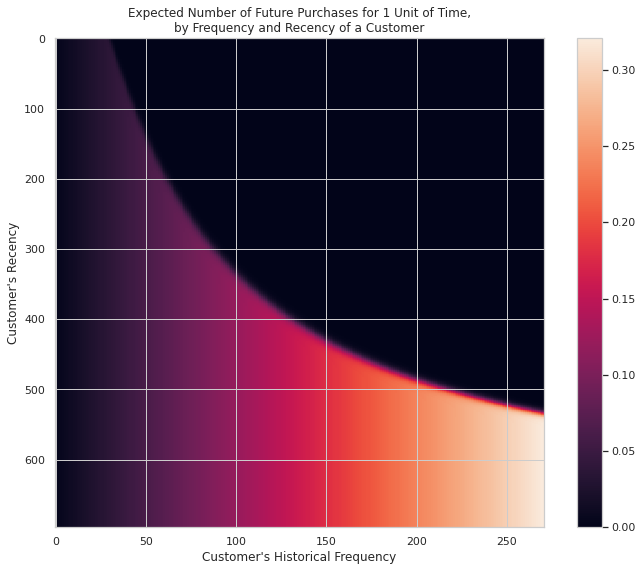

In [ ]:
#Visualizing BG/NBD Model

plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()


In [57]:
#Expected Number of Purchases in 3 Months

t = 90 # 30 day period
new['purchase_3months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, new['frequency'], new['recency'], new['T'])
new.sort_values(by='purchase_3months',ascending=False).head(5)

,frequency,recency,T,monetary_value,purchase_3months
CustomerID,,,,,
nan,270.0,696.0,696.0,4446.378593,28.871611
12748.0,112.0,692.0,696.0,247.955804,12.143960
17841.0,110.0,694.0,696.0,345.403273,11.932218
15311.0,88.0,688.0,696.0,386.838636,9.603051
14606.0,88.0,692.0,696.0,125.973523,9.603051
